## Imports ##

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

import pandas as pd
import pickle
import numpy as np

#### Datasets

In [4]:
# drugs
drugs = pd.read_csv('./data/drugs.csv', index_col=1)
drugs.drop(['Unnamed: 0'], axis=1, inplace=True)

# cell lines
cell_lines = pd.read_csv('./data/gene_expression.csv', index_col=0)

# combinations
combinations = pd.read_csv('./data/combinations.csv', index_col=0)

In [5]:
# reduce cell lines to the 2128 most important genes

with open('./data/2128_genes.pkl', 'rb') as f:
    top_genes = pickle.load(f)

filtered_cell_lines = cell_lines[cell_lines.columns.intersection(top_genes)]

In [6]:
filtered_cell_lines

,FUCA2,GCLC,STPG1,CYP26B1,NDUFAB1,ABCB5,DVL2,HOXA11,COPZ2,CREBBP,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
HCC1954,7.553067,9.280913,3.372573,3.777488,10.985991,2.902166,4.193197,3.967413,3.356586,5.688428,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
HCC1143,8.440833,8.005206,3.920152,3.210161,10.541755,2.877320,5.040755,6.764679,4.920267,5.519528,...,4.663152,3.235018,6.002967,6.837048,3.135009,3.479925,3.393041,7.479672,3.238828,2.564325
HCC1187,5.551352,5.032812,3.528140,3.247300,10.967920,2.934802,4.944361,2.851308,3.645263,5.802317,...,4.656409,5.170385,6.394137,6.492606,3.192293,3.580566,6.013642,8.186395,3.350337,2.914548
HCC1395,8.245466,5.650228,4.185011,3.259254,11.115642,2.933936,5.516593,3.286230,3.768223,5.700710,...,5.917166,3.719701,5.434950,6.151482,3.192478,3.430052,3.542136,8.426703,3.334150,2.641512
HCC1599,7.464137,6.321866,3.531019,5.513162,11.556747,2.998914,4.427619,4.466376,3.336529,6.209780,...,5.204575,6.172346,6.329224,7.900965,2.989608,3.189426,5.394498,8.710373,3.201282,2.749716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCC010,8.031837,6.249088,3.978721,2.909780,11.181177,2.976709,4.335160,3.422648,3.871866,5.911000,...,3.595436,2.765286,5.695328,7.166143,2.982351,3.260054,3.129891,8.034300,3.532607,2.621257
RCC-JW,7.988237,4.217507,3.394038,2.684415,10.388300,3.006199,5.041662,3.457660,7.311520,4.917703,...,3.836706,4.589799,5.231567,6.250817,2.912933,3.436972,3.731778,8.165442,3.789976,2.609469
MM1S,6.453126,5.564713,3.394151,3.028858,11.651180,3.102640,5.167779,2.848341,4.205521,6.021638,...,3.983349,4.146940,5.640954,6.672501,3.203864,3.294515,4.703204,8.485069,3.427507,2.669626
SNU-61,8.947314,6.013510,3.725530,3.029182,11.244912,3.123017,4.957366,5.788725,4.130588,6.112583,...,4.522754,2.724952,5.866326,5.720577,3.067657,3.452590,3.529156,8.440759,3.312884,2.772584


### Merge data

In [7]:
drugs

,Drug
Drug_ID,
Camptothecin,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...
Vinblastine,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...
Cisplatin,N.N.[Cl-].[Cl-].[Pt+2]
Cytarabine,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...
Docetaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
...,...
LJI308,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
GSK591,C1CC(C1)NC2=NC=CC(=C2)C(=O)NC[C@@H](CN3CCC4=CC...
VE821,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...


In [8]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

drugs['Drug'] = drugs['Drug'].apply(smiles_to_maccs)
drugs

,Drug
Drug_ID,
Camptothecin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Vinblastine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Cisplatin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
Cytarabine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Docetaxel,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
...,...
LJI308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
GSK591,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
VE821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
drugs = pd.concat([drugs.drop(['Drug'], axis=1), drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp157,fp158,fp159,fp160,fp161,fp162,fp163,fp164,fp165,fp166
Drug_ID,,,,,,,,,,,,,,,,,,,,,
Camptothecin,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Vinblastine,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisplatin,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
Cytarabine,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
Docetaxel,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LJI308,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
GSK591,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
VE821,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


In [10]:
# merge cell lines and drugs considering the combinations
final_df = pd.merge(combinations, drugs, on='Drug_ID')
final_df = pd.merge(final_df, filtered_cell_lines, left_on='Cell Line_ID', right_index=True, how = 'inner')
final_df.index = final_df['Drug_ID'] + '_' + final_df['Cell Line_ID']
final_df

,Drug_ID,Cell Line_ID,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Camptothecin_HCC1954,Camptothecin,HCC1954,-0.251083,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Vinblastine_HCC1954,Vinblastine,HCC1954,-3.058914,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cisplatin_HCC1954,Cisplatin,HCC1954,5.005908,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cytarabine_HCC1954,Cytarabine,HCC1954,3.947056,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Docetaxel_HCC1954,Docetaxel,HCC1954,-4.177968,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK-2206_HCC202,MK-2206,HCC202,1.585069,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Palbociclib_HCC202,Palbociclib,HCC202,4.867165,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Pictilisib_HCC202,Pictilisib,HCC202,0.583059,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
5-Fluorouracil_HCC202,5-Fluorouracil,HCC202,5.998151,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746


### Dataset splitting ###

In [11]:
output = final_df['Y']
input = final_df.drop(['Drug_ID', 'Cell Line_ID', 'Y'], axis=1)


In [12]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(input)
# input = scaler.transform(input)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3, random_state=42)

In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64892, 2256), (64892,), (27811, 2256), (27811,))

In [15]:
x_train

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
SCH772984_NCI-H1650,0,0,0,0,0,0,0,0,0,0,...,4.620764,4.349685,6.059630,6.196544,2.969417,3.440274,3.671900,8.290864,3.462764,2.598925
Obatoclax Mesylate_NCI-H1944,0,0,0,0,0,0,0,0,0,0,...,4.612394,3.852190,6.275888,7.392892,2.842712,3.200384,3.091870,8.878751,3.419733,2.557954
CZC24832_SW1417,0,0,0,0,0,0,0,0,0,0,...,3.616349,2.757413,5.190664,5.445159,3.046510,3.419467,3.528807,8.456403,3.623589,2.622045
Dactolisib_SAT,0,0,0,0,0,0,0,0,0,0,...,4.637689,2.859829,6.172101,7.168179,3.061090,3.442887,3.679835,8.601642,3.270608,2.601103
Docetaxel_NCI-H2347,0,0,0,0,0,0,0,0,1,0,...,4.827587,3.319316,6.296938,5.994890,2.933983,3.550379,4.037000,8.407811,3.447486,2.603918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paclitaxel_SW1463,0,0,0,0,0,0,0,0,1,0,...,4.793499,4.738768,6.726044,5.808590,2.832737,3.678759,4.410979,8.231673,3.377068,3.009807
PCI-34051_SW13,0,0,0,0,0,0,0,0,0,0,...,7.431876,5.307546,6.100985,7.412594,2.729974,3.424994,4.368461,8.379001,3.570834,2.689459
Sepantronium bromide_OVISE,0,0,0,0,0,0,0,0,0,0,...,4.974294,5.191628,5.651242,6.762516,2.920320,3.273082,4.012576,7.305948,3.768384,2.655434
MK-2206_HCC2218,0,0,0,0,0,0,0,0,0,0,...,4.061743,3.632399,6.157377,6.432589,3.374558,3.612480,3.698259,8.743277,3.809671,2.523288


### Clustering

In [16]:
final_df

,Drug_ID,Cell Line_ID,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Camptothecin_HCC1954,Camptothecin,HCC1954,-0.251083,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Vinblastine_HCC1954,Vinblastine,HCC1954,-3.058914,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cisplatin_HCC1954,Cisplatin,HCC1954,5.005908,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cytarabine_HCC1954,Cytarabine,HCC1954,3.947056,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Docetaxel_HCC1954,Docetaxel,HCC1954,-4.177968,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK-2206_HCC202,MK-2206,HCC202,1.585069,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Palbociclib_HCC202,Palbociclib,HCC202,4.867165,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Pictilisib_HCC202,Pictilisib,HCC202,0.583059,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
5-Fluorouracil_HCC202,5-Fluorouracil,HCC202,5.998151,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746


PCA

numeber of componets for explaned variance: 430


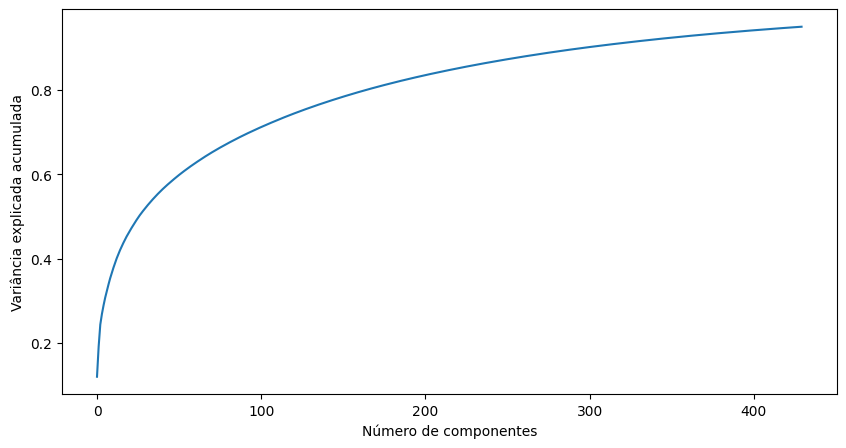

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=0.95)
pca.fit(input)

cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

# number if pca for 0.95 variance
print('numeber of componets for explaned variance:', pca.n_components_)

# plot cumulative variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance_ratio)
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.show()



To explain 95% of the variance, it's needed 355 components from the original 2259.

In [18]:
pca = PCA(n_components=0.8)
pca.fit(input)

cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, '%')
# number if pca for 80% variance
print('numeber of componets for explaned variance:', pca.n_components_)

Var. explicada: [0.11981309 0.07146985 0.05226233 0.02526601 0.02053159 0.01835375
 0.01596042 0.01504131 0.01449608 0.01290296 0.01217835 0.01158107
 0.0108895  0.00988286 0.00927259 0.00860995 0.00830444 0.00787271
 0.00756074 0.00690557 0.00680066 0.00658539 0.00634387 0.00624409
 0.00603451 0.00582612 0.00565183 0.00526461 0.00503155 0.00491794
 0.00481902 0.00474288 0.00456243 0.00445731 0.00438912 0.00422691
 0.00417848 0.00409497 0.00397484 0.00388573 0.00372138 0.00366877
 0.00353826 0.00351336 0.0034239  0.00334434 0.00333404 0.00327817
 0.0032704  0.00318814 0.00311392 0.00306871 0.00298999 0.00295236
 0.00290185 0.00286073 0.00283857 0.00279862 0.00274352 0.00269514
 0.00265071 0.00264131 0.00260848 0.00257876 0.00255177 0.00254179
 0.00251666 0.00244473 0.00243098 0.0023748  0.00234944 0.00230792
 0.00228276 0.00227118 0.00225488 0.00223729 0.00217876 0.00215315
 0.00214748 0.002114   0.00209694 0.0020893  0.00206314 0.00204325
 0.00204099 0.00199835 0.00197034 0.0019659  0

To explain 80% of the variance, it's needed 96 components from the original 2259. In this case, this is a considerable reduction of the dimensionality.

### PCA train and test

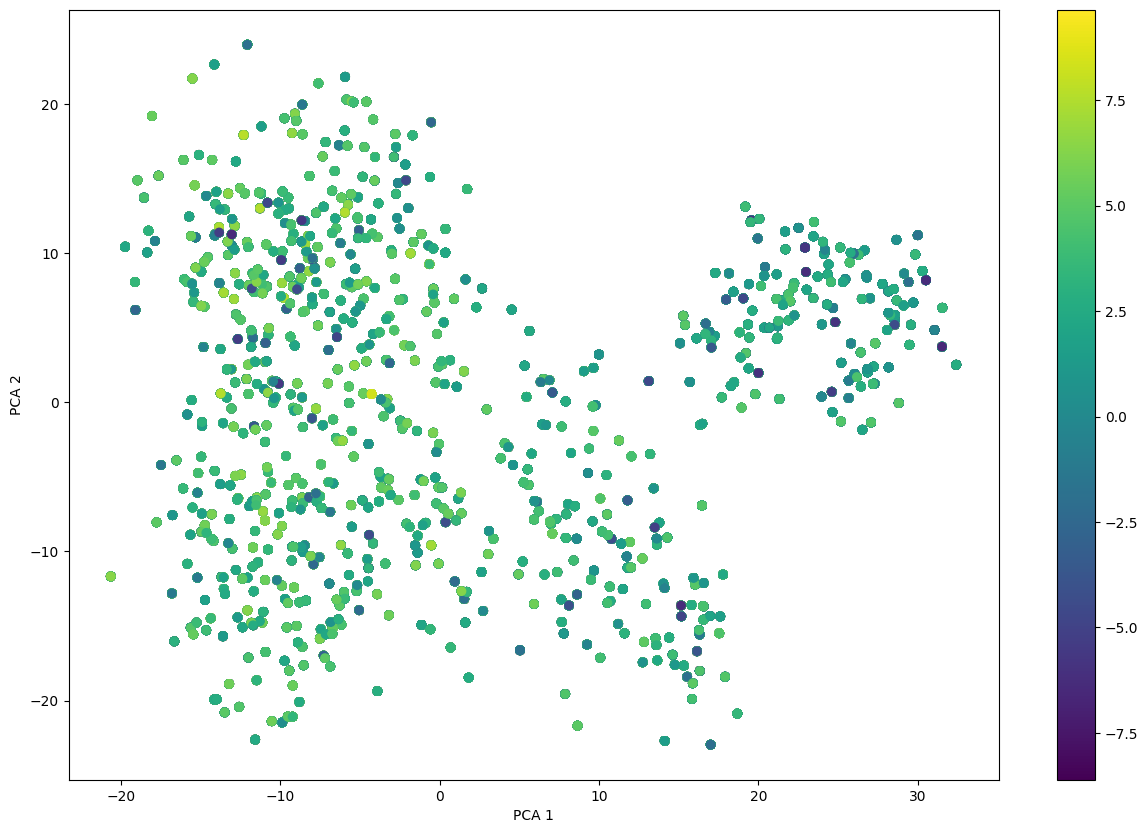

In [19]:
pca = PCA(n_components=96)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

# make plot of pca with gradient color

plt.figure(figsize=(15, 10))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()


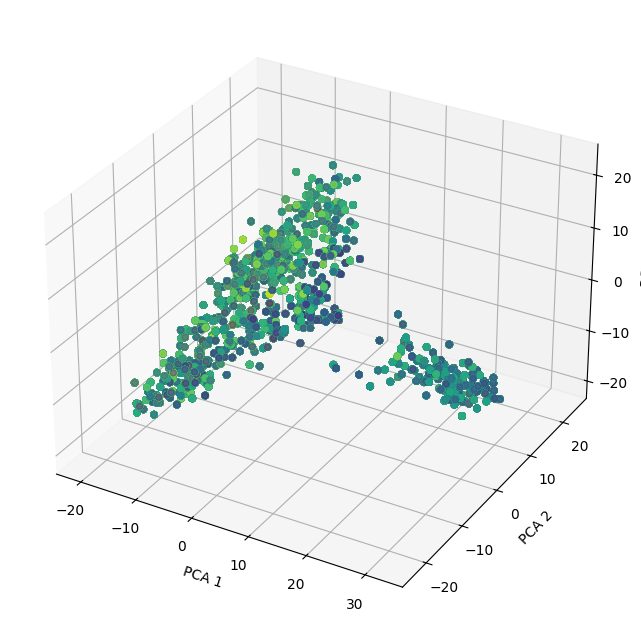

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming that your classes are stored in y_train
ax.scatter(x_train_pca[:, 0], x_train_pca[:, 1], x_train_pca[:, 2], c=y_train, cmap='viridis')

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_adjustable('datalim')
plt.show()

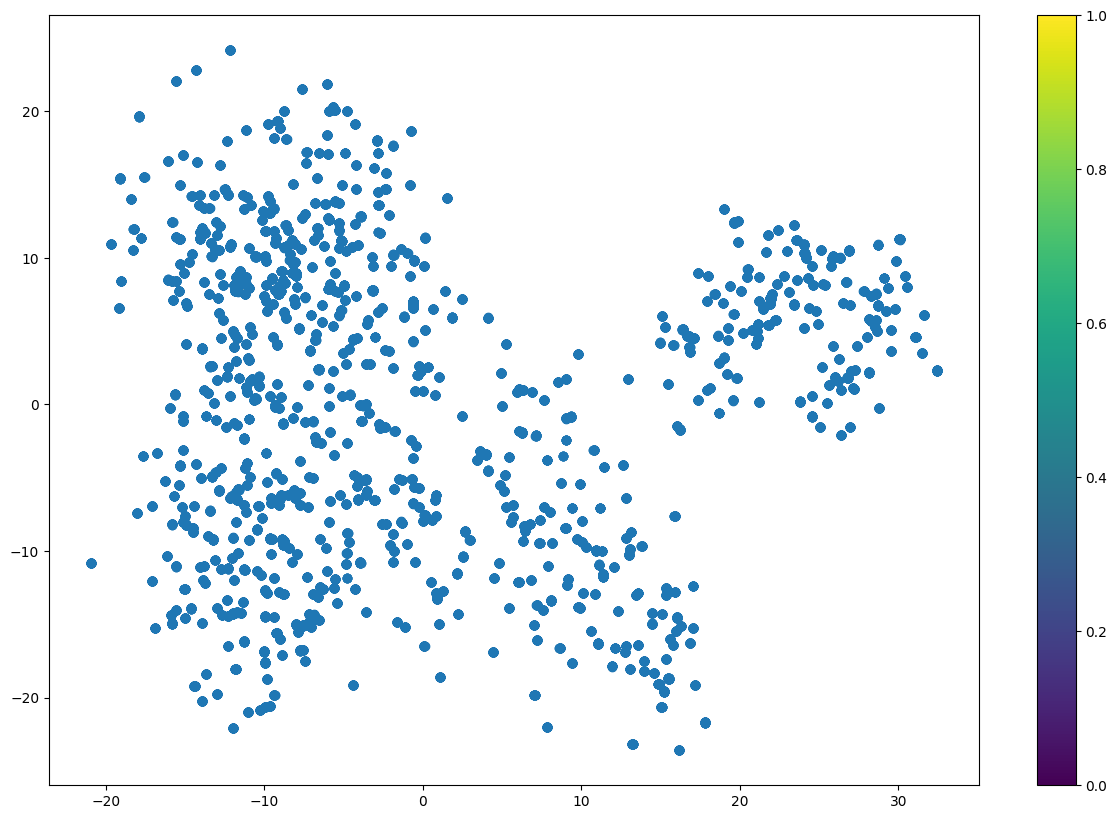

In [21]:
#pca test plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(x_test)
x_test_pca = pca.transform(x_test)

# make image bigger
plt.rcParams['figure.figsize'] = [15, 10]
plt.scatter(x_test_pca[:,0], x_test_pca[:,1])
plt.colorbar()
plt.show()

# Machine learning Models

### linear

In [22]:
# #build pipeline with scaler and linear regression
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression

# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regression', LinearRegression())
# ])

# pipeline.fit(x_train, y_train)

# # cross validation
# y_pred = pipeline.predict(x_test)
# print('Linear Regression')
# print('MAE: ', mean_absolute_error(y_test, y_pred))
# print('MSE: ', mean_squared_error(y_test, y_pred))
# print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
# print('R2: ', r2_score(y_test, y_pred))


In [23]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Linear Regression')
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2: ', r2_score(y_test, y_pred))





Linear Regression
MAE:  0.8770865017821186
MSE:  1.4023694272617702
RMSE:  1.1842167990962509
R2:  0.8100185089160812


In [24]:
print(y_pred[:10])
print(*y_test[:10])

[ 3.18652344  2.66601562 -0.4921875  -3.96191406  4.19042969  3.73828125
  4.77246094  5.53710938  0.89160156  0.74804688]
3.292333 1.502017 -2.550424 -4.308333 3.559687 2.719596 5.262041 5.50276 0.127412 0.585525


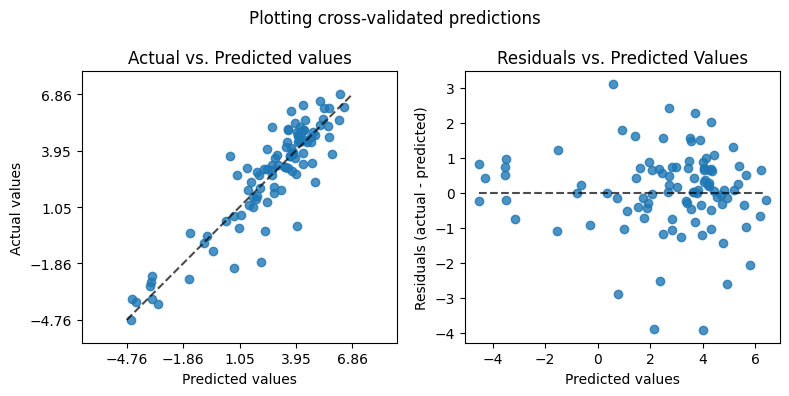

In [25]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

### SVR

In [26]:
svr = SVR()
svr.fit(x_train, y_train)
y_pred = svr.predict(x_test)
print('SVR')
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))


SVR
MAE:  1.5266755343846274
MSE:  4.574318121723913
RMSE:  2.1387655602529025


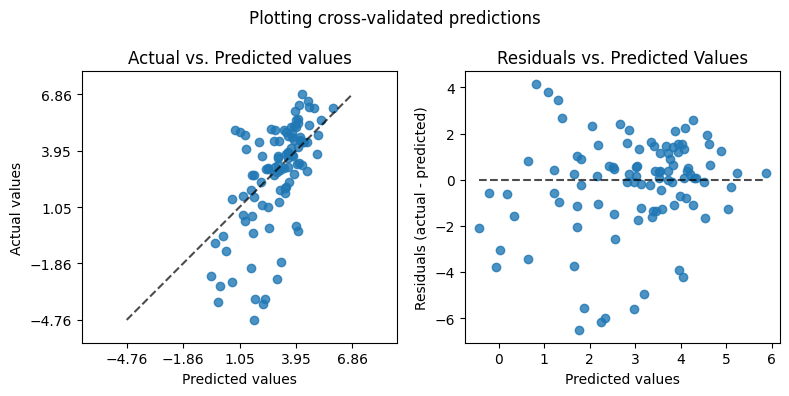

In [27]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()